# Customer segmentation
_Jayeeta Ghosh (Aug 2018)_

____
### Explore Transaction Dataset
This notebook is meant to be the Exploratory Data Analytis on sample transaction data for time window 2017/01/29 to 2017/03/30. Customer level aggregated data was created based on the understanding from this analysis. Goal is to run for one fiscal year once the logic is formalized properly. 

### Workflow: 
Number of records for 2 months between '2017-01-29' and '2017-03-30 - 7,686,468, though the plan is to go atleast one fiscal year <br />

Define number of transaction data to pull: 100K, takes about 2 mins

1. Check duplicates and remove if exists
2. Remove variables that are >90% null, and all constant variables
3. Run plain descriptive statistics
4. Make sure to check if the datatypes are correct, otherwise change into proper types including date, numerical and object type
5. Check unique counts on categorical features, remove the ones that are less intuitive, and impute missing ones using string "Missing"
6. Make simple bar plots to gather a sense of important ones
7. Get all the numerical columns and create correlation plot
8. Understand the relationship between corp, comp, div, dept, and class. Get a sense of best setting div/dept etc
9. Understand season_code and season_desc. Decipher the code into regular and marked down purchase
10. Check on discount amount. Discounts are represented as negative quantity but positive discount is added for return items
11. Check on promotion $ and \%, get a sense of popular ones

In [1]:
import sys, os, time
sys.path.append('/mnt/Opaisle/resources/python/')
# sys.path.append('/home/ubuntu/.local/lib/python3.4/site-packages')
sys.path.insert(0, '/home/ubuntu/.local/lib/python3.4/site-packages')
import helper_functions as gp
import pandas as pd

In [2]:
# set display right
pd.set_option('display.width', 4000)
pd.set_option('max_colwidth', 4000)
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 200)

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime#, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
# from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
# import plotly.graph_objs as go
# from plotly.offline import init_notebook_mode,iplot
# init_notebook_mode(connected=True)
# warnings.filterwarnings("ignore")
# plt.rcParams["patch.force_edgecolor"] = True
# plt.style.use('fivethirtyeight')
# mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

%matplotlib inline

In [4]:
# Data directory
DataDir = "Input/"
OutDir = "Output/"

In [5]:
query_list = [
    """
    SELECT  TOP 1000000 *
    FROM
        --dbo.cust_trn2
        --dbo.cust_trn_agg
        
        --dbo.cust_trn
        --
        
    ORDER BY
        customer_key, transaction_num, line_num
    
    """
]

In [6]:
%%time
df = gp.dmno_execute(query_list, connection='azure')
# 100,000 data pull took 1 min 51s - beyond peak hour
# 1M data pull: 10min 45s

COMPLETED! 644.53 seconds.
CPU times: user 10min 49s, sys: 5.74 s, total: 10min 54s
Wall time: 10min 45s


In [80]:
# Just read sample data
# df = pd.read_csv(DataDir +"cust_trn100K.csv")

In [7]:
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (1000000, 33)


In [8]:
# Save this dataframe for now - specially to run eda faster
df.to_csv(DataDir + "cust_trn1M.csv", index=False)

### 1. Check duplicates and remove if exists

In [9]:
# Check duplicate rows if exists
print('Duplicates: {}'.format(df.duplicated().sum()))

Duplicates: 499993


In [10]:
# Remove duplicate rows if exists
print('Dataframe dimensions before:', df.shape)
df.drop_duplicates(inplace = True)
print('Dataframe dimensions after:', df.shape)

Dataframe dimensions before: (1000000, 33)
Dataframe dimensions after: (500007, 33)


### 2. Remove variables that are >90% null, and all constant variables

In [11]:
# Drop columns that are >90% null
print('Dataframe dimensions before:', df.shape)
df = df.dropna(thresh=0.1*len(df), axis=1)
print('Dataframe dimensions after:', df.shape)

Dataframe dimensions before: (500007, 33)
Dataframe dimensions after: (500007, 33)


In [12]:
# Lets remove constant columns
df = df.loc[:,df.apply(pd.Series.nunique) != 1]
print('Dataframe dimensions after:', df.shape)

Dataframe dimensions after: (500007, 32)


### 3. Run plain descriptive statistics

In [13]:
# Drop a few columns before running EDA
# df = df.drop(['discount_reason_cd', 'discount_seq_nbr','discount_level', 'mkt_pmotn_cd', 'style_cd',
#               'color_cd','market_code', 'style_color_cd', 'size_model_cd',  
#                 'instore_date2', 'markdown_date2', 
#                ], axis=1)
df = df.drop(['discount_reason_cd', 'discount_seq_nbr','discount_level', 'mkt_pmotn_cd'], axis=1)

In [15]:
df.head()

,customer_key,transaction_num,transaction_date,line_num,order_status,product_key,item_qty,sales_amt,on_sale_flag,tot_prd_cst_amt,discount_amt,promo_cd_key,prod_desc,mdse_div_id,mdse_div_desc,mdse_dept_id,mdse_dept_desc,mdse_class_id,mdse_class_desc,dept_sty_desc,season_desc,season_cd,promo_code,promo_desc,eff_date,end_date,daysinto_promo,num_promodays
0,376,2127158002,2017-03-09,1,R,5426881499,1,38.0,N,7.24,-19.00,38803531.0,SKNY SCALLOP BBLK800,13,ACCESSORIES,132,W ACCESSORIES,01,W BELTS,SKNY SCALLOP,F05 2017,F05,295293,50% off up to 5 reg-price items lease line,08-MAR-17,14-MAR-17,6.0,1.0
2,376,2127158002,2017-03-09,1,R,5426881499,1,38.0,N,7.24,-1.90,38267717.0,SKNY SCALLOP BBLK800,13,ACCESSORIES,132,W ACCESSORIES,01,W BELTS,SKNY SCALLOP,F05 2017,F05,289493,"save 10% off purchase when you use your banana republic, gap, old navy or athleta card",20-FEB-17,20-MAY-17,89.0,17.0
4,376,2127158002,2017-03-09,2,R,5426883949,1,39.5,N,9.55,-19.75,38803531.0,SL OTS SLD SCA445 GERD,12,WOMENS,125,W KNITS,03,TANK SLEEVELESS,SL OTS SLD S,M04 2017,M04,295293,50% off up to 5 reg-price items lease line,08-MAR-17,14-MAR-17,6.0,1.0
6,376,2127158002,2017-03-09,2,R,5426883949,1,39.5,N,9.55,-1.98,38267717.0,SL OTS SLD SCA445 GERD,12,WOMENS,125,W KNITS,03,TANK SLEEVELESS,SL OTS SLD S,M04 2017,M04,289493,"save 10% off purchase when you use your banana republic, gap, old navy or athleta card",20-FEB-17,20-MAY-17,89.0,17.0
8,376,2127158002,2017-03-09,3,R,5328211222,1,148.0,N,36.03,-7.40,38267717.0,NAVY PINSTRIP PREPNAVY,12,WOMENS,121,W SUIT/SEP,01,SUIT TOPS,NAVY PINSTRI,F04 2017,F04,289493,"save 10% off purchase when you use your banana republic, gap, old navy or athleta card",20-FEB-17,20-MAY-17,89.0,17.0


In [16]:
df.describe()

,customer_key,transaction_num,line_num,product_key,item_qty,sales_amt,tot_prd_cst_amt,discount_amt,promo_cd_key,daysinto_promo,num_promodays
count,5.000070e+05,5.000070e+05,500007.000000,5.000070e+05,500007.000000,500007.000000,500007.000000,437152.000000,3.418160e+05,341816.000000,341816.000000
mean,2.265609e+06,2.128118e+09,2.744772,5.173306e+09,0.590864,36.890680,9.871818,-9.210905,3.646690e+07,46.609366,77.664384
std,1.333772e+06,3.260027e+07,2.566618,8.657558e+08,0.823907,77.453071,21.329191,25.936637,4.503451e+06,1781.165550,299.354369
min,3.760000e+02,2.108580e+09,1.000000,5.638200e+04,-8.000000,-2399.990000,-750.280000,-959.990000,2.283770e+05,-24107.000000,0.000000
25%,1.152987e+06,2.116854e+09,1.000000,5.057281e+09,1.000000,14.980000,3.560000,-19.750000,3.511587e+07,7.000000,6.000000
50%,2.231697e+06,2.126782e+09,2.000000,5.426883e+09,1.000000,48.000000,13.000000,-5.000000,3.803902e+07,89.000000,23.000000
75%,3.411143e+06,2.131794e+09,3.000000,5.590440e+09,1.000000,78.000000,19.480000,-1.010000,3.845880e+07,243.000000,71.000000
max,4.596456e+06,2.918421e+09,50.000000,6.190992e+09,10.000000,2399.990000,1661.630000,959.990000,3.961513e+07,4726.000000,3553.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500007 entries, 0 to 999999
Data columns (total 28 columns):
customer_key        500007 non-null int64
transaction_num     500007 non-null int64
transaction_date    500007 non-null object
line_num            500007 non-null int64
order_status        500007 non-null object
product_key         500007 non-null int64
item_qty            500007 non-null int64
sales_amt           500007 non-null float64
on_sale_flag        500007 non-null object
tot_prd_cst_amt     500007 non-null float64
discount_amt        437152 non-null float64
promo_cd_key        341816 non-null float64
prod_desc           437152 non-null object
mdse_div_id         437152 non-null object
mdse_div_desc       437152 non-null object
mdse_dept_id        437152 non-null object
mdse_dept_desc      437152 non-null object
mdse_class_id       437152 non-null object
mdse_class_desc     437152 non-null object
dept_sty_desc       437152 non-null object
season_desc         437152 non

In [18]:
# df.dtypes
df.columns

Index(['customer_key', 'transaction_num', 'transaction_date', 'line_num', 'order_status', 'product_key', 'item_qty', 'sales_amt', 'on_sale_flag', 'tot_prd_cst_amt', 'discount_amt', 'promo_cd_key', 'prod_desc', 'mdse_div_id', 'mdse_div_desc', 'mdse_dept_id', 'mdse_dept_desc', 'mdse_class_id', 'mdse_class_desc', 'dept_sty_desc', 'season_desc', 'season_cd', 'promo_code', 'promo_desc', 'eff_date', 'end_date', 'daysinto_promo', 'num_promodays'], dtype='object')

In [19]:
# Get some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,customer_key,transaction_num,transaction_date,line_num,order_status,product_key,item_qty,sales_amt,on_sale_flag,tot_prd_cst_amt,discount_amt,promo_cd_key,prod_desc,mdse_div_id,mdse_div_desc,mdse_dept_id,mdse_dept_desc,mdse_class_id,mdse_class_desc,dept_sty_desc,season_desc,season_cd,promo_code,promo_desc,eff_date,end_date,daysinto_promo,num_promodays
column type,int64,int64,object,int64,object,int64,int64,float64,object,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,62855,158191,62855,62855,62855,62855,62855,62855,62855,62855,62855,62855,158191,158191,158191,158191,158191,158191
null values (%),0,0,0,0,0,0,0,0,0,0,12.5708,31.6378,12.5708,12.5708,12.5708,12.5708,12.5708,12.5708,12.5708,12.5708,12.5708,12.5708,31.6378,31.6378,31.6378,31.6378,31.6378,31.6378


### 4. Make sure to check if the datatypes are correct, otherwise change into proper types including date, numerical and object type

In [21]:
# Change date variables to date type
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['eff_date'] = pd.to_datetime(df['eff_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

In [22]:
print(min(df['transaction_date']))
print(max(df['transaction_date']))

2017-01-29 00:00:00
2018-02-27 00:00:00


In [41]:
# df.dtypes

In [23]:
# Change a few numerical columns to string
colsToString = ['customer_key', 'transaction_num', 'product_key', 'on_sale_flag', 
                 'promo_cd_key']#, 'regular_priced', 'markdown_priced']
df[colsToString] = df[colsToString].astype(str)

In [24]:
# Get some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,customer_key,transaction_num,transaction_date,line_num,order_status,product_key,item_qty,sales_amt,on_sale_flag,tot_prd_cst_amt,discount_amt,promo_cd_key,prod_desc,mdse_div_id,mdse_div_desc,mdse_dept_id,mdse_dept_desc,mdse_class_id,mdse_class_desc,dept_sty_desc,season_desc,season_cd,promo_code,promo_desc,eff_date,end_date,daysinto_promo,num_promodays
column type,object,object,datetime64[ns],int64,object,object,int64,float64,object,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,datetime64[ns],datetime64[ns],float64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,62855,0,62855,62855,62855,62855,62855,62855,62855,62855,62855,62855,158191,158191,158191,158191,158191,158191
null values (%),0,0,0,0,0,0,0,0,0,0,12.5708,0,12.5708,12.5708,12.5708,12.5708,12.5708,12.5708,12.5708,12.5708,12.5708,12.5708,31.6378,31.6378,31.6378,31.6378,31.6378,31.6378


### 5. Check unique counts on categorical features, remove the ones that are less intuitive, and impute missing ones using string "Missing"
Lets explore a few categorical columns. We need to make sure which variables are important for customers

In [25]:
# Consider all categorical columns
catData = df.select_dtypes(include=['object'])
catCol = catData.columns
print(catCol)
catColToImpute = [item for item in catCol if item not in 
                  ['customer_key', 'transaction_num', 'product_key']]
print(catColToImpute)


Index(['customer_key', 'transaction_num', 'order_status', 'product_key', 'on_sale_flag', 'promo_cd_key', 'prod_desc', 'mdse_div_id', 'mdse_div_desc', 'mdse_dept_id', 'mdse_dept_desc', 'mdse_class_id', 'mdse_class_desc', 'dept_sty_desc', 'season_desc', 'season_cd', 'promo_code', 'promo_desc'], dtype='object')
['order_status', 'on_sale_flag', 'promo_cd_key', 'prod_desc', 'mdse_div_id', 'mdse_div_desc', 'mdse_dept_id', 'mdse_dept_desc', 'mdse_class_id', 'mdse_class_desc', 'dept_sty_desc', 'season_desc', 'season_cd', 'promo_code', 'promo_desc']


In [26]:
df.fillna({x:'Missing' for x in catColToImpute}, inplace=True)

In [27]:
# unique counts
def unique_counts(sample):
   for i in sample.columns:
       count = sample[i].nunique()
       print(i, ": ", count)
unique_counts(df[catColToImpute])

order_status :  2
on_sale_flag :  2
promo_cd_key :  454
prod_desc :  6549
mdse_div_id :  14
mdse_div_desc :  8
mdse_dept_id :  54
mdse_dept_desc :  28
mdse_class_id :  11
mdse_class_desc :  72
dept_sty_desc :  3579
season_desc :  200
season_cd :  104
promo_code :  454
promo_desc :  106


In [28]:
# Categorical columns for plot
catColPlot = [item for item in catColToImpute if item not in ['prod_desc',  'promo_cd_key', 
                                                      'mdse_dept_id', 'mdse_dept_desc', 
                                                      'mdse_class_id', 'mdse_class_desc',
                                                      'dept_sty_desc', 'season_desc', 'season_cd',
                                                      'promo_code', 'promo_desc']]
print(catColPlot)

['order_status', 'on_sale_flag', 'mdse_div_id', 'mdse_div_desc']


In [29]:
# # check on order status
# idcol = ['customer_key', 'transaction_num', 'order_status']
# dfcat = df[idcol]
# print(dfcat.shape)
# dfcat.head()

In [30]:
# dfcat2 = dfcat.drop_duplicates(subset=['customer_key', 'transaction_num'], keep='last')
# print(dfcat2.shape) # 28789
# dfcat2.head()

In [75]:
def cat_graph(graph_title,ss):
    sns.set_style("whitegrid")
    plt.figure(figsize=(5,5))
    ax = sns.barplot(y="count", x='type', data=ss)
    ax.set(xlabel='', ylabel='', title=graph_title)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#     plt.figure(figsize=(15,8))
    plt.savefig(OutDir + graph_title + '.png')
    plt.show()

In [76]:
# # Plot order status
# for c in ['order_status']:
#     ss = pd.value_counts(dfcat2[c]).to_frame().reset_index()
#     ss.columns = ['type', 'count']
#     graph_name = 'Distribution of Categorical ' + c
#     cat_graph(graph_name, ss)

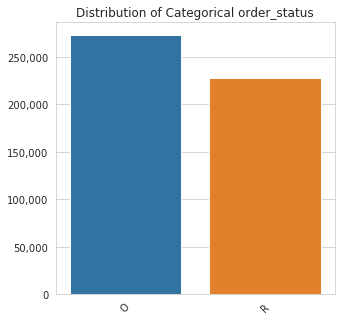

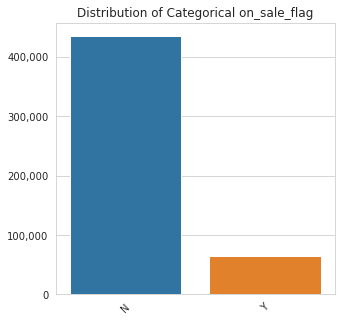

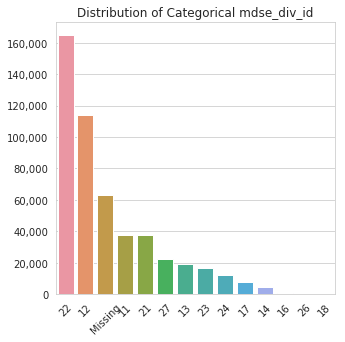

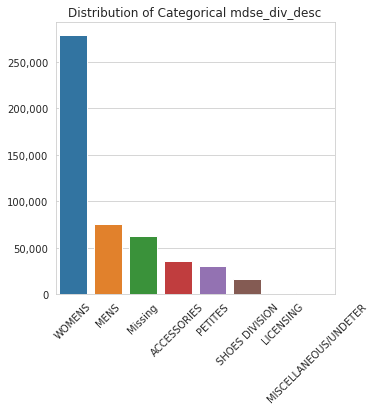

In [77]:
# Plot categorical columns
for c in catColPlot:
    ss = pd.value_counts(df[c]).to_frame().reset_index()
    ss.columns = ['type', 'count']
    graph_name = 'Distribution of Categorical ' + c
    cat_graph(graph_name, ss)

In [ ]:
# This plot is misleading as this is just counting number of occurance of  O/R, 
# should be transaction level grouping

### 7. Get all the numerical columns and create correlation plot

In [78]:
# Get all the numeric columns
numerics = ['float64', 'int32', 'int64']
numData = df.select_dtypes(include=numerics)
numCol = numData.columns
print(numCol)

Index(['line_num', 'item_qty', 'sales_amt', 'tot_prd_cst_amt', 'discount_amt', 'daysinto_promo', 'num_promodays'], dtype='object')


In [79]:
# Imputation - with 0 (discount_amt, any other cont. variables)
df.fillna({x:0 for x in numCol}, inplace=True) 
# df.fillna({x:0 for x in ['discount_amt']}, inplace=True) 

In [80]:
# Get some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,customer_key,transaction_num,transaction_date,line_num,order_status,product_key,item_qty,sales_amt,on_sale_flag,tot_prd_cst_amt,discount_amt,promo_cd_key,prod_desc,mdse_div_id,mdse_div_desc,mdse_dept_id,mdse_dept_desc,mdse_class_id,mdse_class_desc,dept_sty_desc,season_desc,season_cd,promo_code,promo_desc,eff_date,end_date,daysinto_promo,num_promodays
column type,object,object,datetime64[ns],int64,object,object,int64,float64,object,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,datetime64[ns],datetime64[ns],float64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,158191,158191,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.6378,31.6378,0,0


In [81]:
numColPlot = [item for item in numCol if item not in ['line_num']]
numColPlot

['item_qty',
 'sales_amt',
 'tot_prd_cst_amt',
 'discount_amt',
 'daysinto_promo',
 'num_promodays']

In [82]:
def num_graph(graph_title,ss):
    sns.distplot(ss)
    plt.savefig(OutDir + graph_title + '.png')
    plt.show()

/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


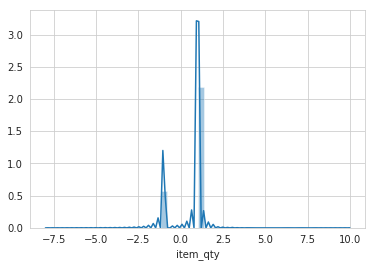

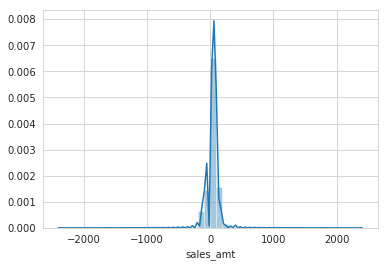

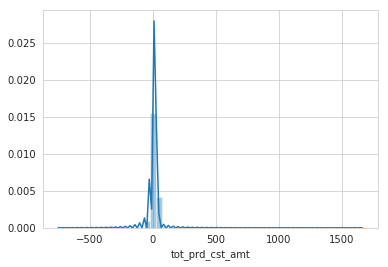

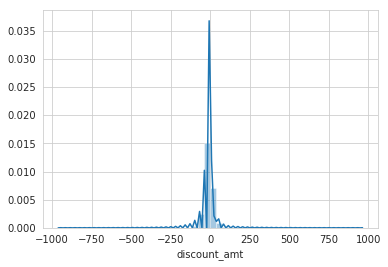

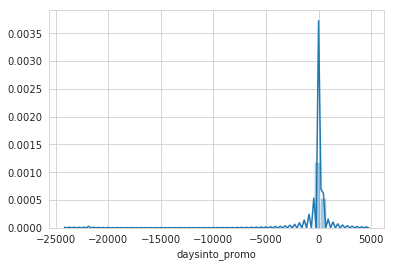

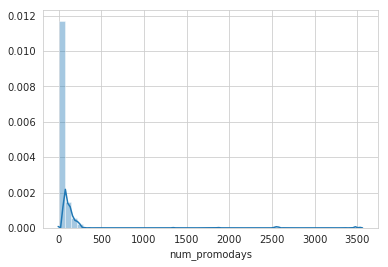

In [83]:
# Plot distribution of numerical features
for c in numColPlot:
    ss = df[c]
    graph_name = 'Distribution_' + c
    num_graph(graph_name, ss)

/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


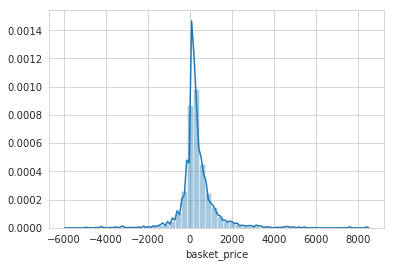

In [75]:
sns.distplot(df['basket_price'])

/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


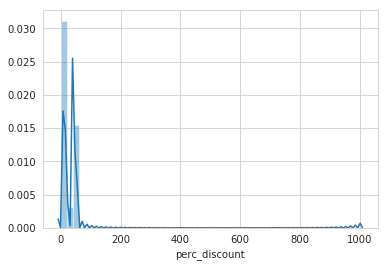

In [80]:
# df['perc_discount'] = 100.0 * (-df['discount_amt'])/df['sales_amt']
sns.distplot(df['perc_discount'])

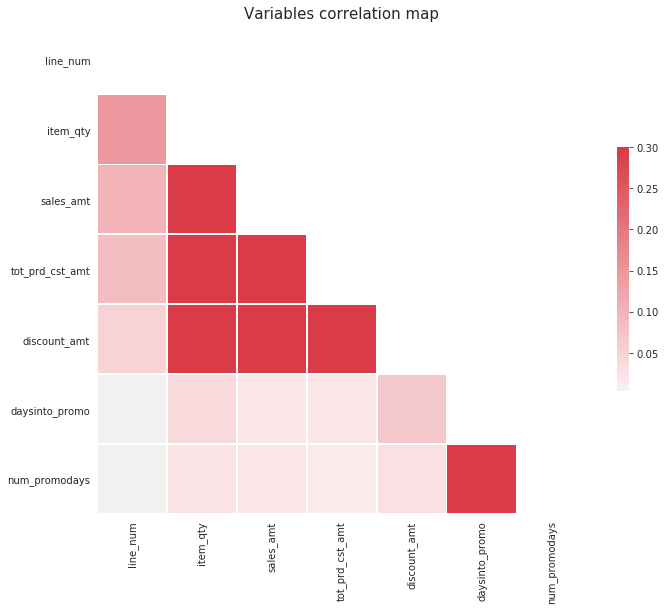

In [84]:
# Get correlation between the numerical columns
corr = abs(numData.corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Variables correlation map", fontsize=15)
graph_title = "correlation"
plt.savefig(OutDir + graph_title + '.png')
plt.show()

### 8. Understand the relationship between corp, comp, div, dept, and class. Get a sense of best selling div/dept etc

We are running the whole analysis on Banana Republic, lets make sure we captured that right. Thus corp_id 11/60 both correspond to BR - so we are good

During rerunning - did not bring following columns
--c.mdse_corp_id,
--c.mdse_corp_desc,
--c.mdse_comp_id,
--c.mdse_comp_desc,

In [47]:
# df['mdse_corp_id'].value_counts()

In [186]:
# pd.crosstab(df.mdse_corp_id, df.mdse_corp_desc, margins=True)

mdse_corp_desc,BANANA,BR DIR,Missing,All
mdse_corp_id,,,,
11,18981,0,0,18981
60,0,27446,0,27446
Missing,0,0,6420,6420
All,18981,27446,6420,52847


What is the relationship between corp and comp? For all practical purposes for this analysis we do not need to worry about corp and comp separately

In [15]:
# pd.crosstab(df.mdse_corp_desc, df.mdse_comp_desc, margins=True)

mdse_comp_desc,BANANA REPUBLIC,BRCAT/ONLINE,All
mdse_corp_desc,,,
BANANA,35708,0,35708
BR DIR,0,51964,51964
All,35708,51964,87672


How about corp, div and dept? Definitely WOMENS division is the most popular. 

**Q: Does it make sense to create new feature related to div for customers?**

In [48]:
df['mdse_div_desc'].value_counts()

WOMENS                   55500
MENS                     16655
Missing                  12103
PETITES                   6427
ACCESSORIES               6150
SHOES DIVISION            2973
LICENSING                  173
MISCELLANEOUS/UNDETER       18
BROL FACTORY                 1
Name: mdse_div_desc, dtype: int64

In [42]:
# div = df.groupby(['mdse_comp_desc', 'mdse_div_desc']).agg({'sales_amt': 'sum'})
# # Change: groupby mdse_comp_desc and mdse_div_desc and divide by sum
# div_pcts = div.groupby(level=0).apply(lambda x:
#                                                  100 * x / float(x.sum()))
# div_pcts

sales_amt
mdse_comp_desc  mdse_div_desc                   
BANANA REPUBLIC ACCESSORIES             5.477687
                LICENSING               0.295288
                MENS                   22.175265
                MISCELLANEOUS/UNDETER   0.042236
                PETITES                 4.825897
                SHOES DIVISION          3.565041
                WOMENS                 63.618585
BRCAT/ONLINE    ACCESSORIES             4.607771
                LICENSING               0.060571
                MENS                   22.287504
                PETITES                 9.719280
                SHOES DIVISION          7.336865
                WOMENS                 55.988009

In [49]:
df['mdse_dept_desc'].value_counts()

W KNITS                  12670
Missing                  12103
W SUIT/SEP               11967
W PANTS                  11233
W WOVEN SHIRTS           10970
W SWEATERS                7978
M KNITS                   5573
M PANTS                   5205
M WOVEN SHIRTS            3869
JEWELRY                   2637
W SHOES                   2614
P SUIT/SEP                2465
P PANTS                   1982
W ACCESSORIES             1868
M ACCESSORIES             1495
P WOVEN SHIRTS            1366
MENS SUITING              1101
M SWEATERS                 750
W LEATHERS & OUTW          682
M SHOES                    359
P KNITS                    260
P SWEATERS                 202
SUNGLASSES                 173
M OUTERWEAR                157
P LEATHERS & OUTW          152
PERSONAL CARE              104
THIRD PARTY                 46
MISCELLANEOUS/UNDETER       18
BROL FACTORY PETITE          1
Name: mdse_dept_desc, dtype: int64

In [16]:
# pd.crosstab([df.mdse_corp_desc, df.mdse_div_desc],  df.mdse_dept_desc, margins=True)

mdse_dept_desc                        JEWELRY  M ACCESSORIES  M KNITS  M OUTERWEAR  M PANTS  M SHOES  M SWEATERS  M WOVEN SHIRTS  MENS SUITING  MISCELLANEOUS/UNDETER  P KNITS  P LEATHERS & OUTW  P PANTS  P SUIT/SEP  P SWEATERS  P WOVEN SHIRTS  PERSONAL CARE  SUNGLASSES  THIRD PARTY  W ACCESSORIES  W KNITS  W LEATHERS & OUTW  W PANTS  W SHOES  W SUIT/SEP  W SWEATERS  W WOVEN SHIRTS    All
mdse_corp_desc mdse_div_desc                                                                                                                                                                                                                                                                                                                                                                          
BANANA         ACCESSORIES               1380            982        0            0        0        0           0               0             0                      0        0                  0        0           0           0               0             34           0            2           1342        0                  0        0        0           0           0               0   3740
               LICENSING                    0              0        0            0        0        0           0               0             0                      0        0                  0        0           0           0               0              0         113            0              0        0                  0        0        0           0           0               0    113
               MENS                         0              0     2146          116     2074        0         638            1981           429                      0        0                  0        0           0           0               0              0           0            0              0        0                  0        0        0           0           0               0   7384
               MISCELLANEOUS/UNDETER        0              0        0            0        0        0           0               0             0                     32        0                  0        0           0           0               0              0           0            0              0        0                  0        0        0           0           0               0     32
               PETITES                      0              0        0            0        0        0           0               0             0                      0       55                 30      557         387          26             361              0           0            0              0        0                  0        0        0           0           0               0   1416
               SHOES DIVISION               0              0        0            0        0      117           0               0             0                      0        0                  0        0           0           0               0              0           0            0              0        0                  0        0      679           0           0               0    796
               WOMENS                       0              0        0            0        0        0           0               0             0                      0        0                  0        0           0           0               0              0           0            0              0     5238                489     4267        0        3458        4197            4578  22227
BR DIR         ACCESSORIES               1295            620        0            0        0        0           0               0             0                      0        0                  0        0           0           0               0              2           0           66           1434        0                  0        0        0           0           0               0   3417
               LICENSING                    0              0        0            0        

How about div, dept and class? 

**Q: Does it make sense to create new feature related to dept for customers?**

It might be too granular

In [50]:
df['mdse_dept_desc'].value_counts()

W KNITS                  12670
Missing                  12103
W SUIT/SEP               11967
W PANTS                  11233
W WOVEN SHIRTS           10970
W SWEATERS                7978
M KNITS                   5573
M PANTS                   5205
M WOVEN SHIRTS            3869
JEWELRY                   2637
W SHOES                   2614
P SUIT/SEP                2465
P PANTS                   1982
W ACCESSORIES             1868
M ACCESSORIES             1495
P WOVEN SHIRTS            1366
MENS SUITING              1101
M SWEATERS                 750
W LEATHERS & OUTW          682
M SHOES                    359
P KNITS                    260
P SWEATERS                 202
SUNGLASSES                 173
M OUTERWEAR                157
P LEATHERS & OUTW          152
PERSONAL CARE              104
THIRD PARTY                 46
MISCELLANEOUS/UNDETER       18
BROL FACTORY PETITE          1
Name: mdse_dept_desc, dtype: int64

In [51]:
dept = df.groupby(['mdse_div_desc', 'mdse_dept_desc']).agg({'sales_amt': 'sum'})
# Change: groupby mdse_comp_desc and mdse_div_desc and divide by sum
dept_pcts = dept.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
dept_pcts

sales_amt
mdse_div_desc         mdse_dept_desc                   
ACCESSORIES           JEWELRY                 38.133421
                      M ACCESSORIES           19.798358
                      PERSONAL CARE            1.556883
                      THIRD PARTY              1.961941
                      W ACCESSORIES           38.549397
BROL FACTORY          BROL FACTORY PETITE    100.000000
LICENSING             SUNGLASSES             100.000000
MENS                  M KNITS                 17.730333
                      M OUTERWEAR              1.556494
                      M PANTS                 34.002367
                      M SWEATERS               4.354817
                      M WOVEN SHIRTS          23.281261
                      MENS SUITING            19.074729
MISCELLANEOUS/UNDETER MISCELLANEOUS/UNDETER  100.000000
Missing               Missing                100.000000
PETITES               P KNITS                  2.217278
                      P LEATHERS & OUTW        4.030214
                      P PANTS                 30.568498
                      P SUIT/SEP              41.657587
                      P SWEATERS               2.847240
                      P WOVEN SHIRTS          18.679183
SHOES DIVISION        M SHOES                 16.788225
                      W SHOES                 83.211775
WOMENS                W KNITS                 14.050713
                      W LEATHERS & OUTW        2.342574
                      W PANTS                 23.578319
                      W SUIT/SEP              25.432473
                      W SWEATERS              16.005330
                      W WOVEN SHIRTS          18.590590

In [51]:
# df['mdse_class_desc'].value_counts() # Too many to consider

In [52]:
pd.crosstab([df.mdse_div_desc, df.mdse_dept_desc],  df.mdse_class_desc, margins=True)

mdse_class_desc                              5 POCKET DENIM  BAGS  BASIC  BASIC 5 PKT  BASIC HABERDASHERY  BASIC POLOS  BASIC TEES  BOOTS  BOXERS  BRACELETS  CASHMERE  CASHMERE SWEATERS  CLOSED TOE  COATS  COTTON SWEATER  EARRINGS  ELEVATED PANTS  FASHION BOTTOM  FASHION PANTS  FIVE POCKET/DENIM  FRAGRANCE  HAIR ACCESSORIES  HOME FRAGRANCES  ITEMS  JACKETS  L/S CASUAL  LEATHER  LEATHER/SUEDE  LONG SLEEVE  M BELTS  M L/S KNITS  M S/S KNITS  M SEASONAL ACCESSORIES  M SOCKS  MENS SUNGLASSES  MENS THIRD PARTY  MENS UNDERWEAR  MERINO SWEATERS  Missing  NECKLACES  NECKWEAR  NON SEASONAL  NONSEASONAL  NOVELTY/OTHER SWEATERS  NOVELTY/OTHER YARN  NOVT/OTHER YRN SWEATER  OPEN TOE  PETITE WOVENS  RINGS  S/S SHIRTS  SEASONAL  SHORT SLEEVE  SHORTS  SKIRTS  SLEEVELESS  SUIT BLAZERS  SUIT TOPS  SUIT TROUSERS  SWIM  TANK SLEEVELESS  UNDETERMINABLE  VESTS  W BELTS  W SEASONAL ACCESSORIES  W SOCKS  WOMENS SUNGLASSES  WOMENS THIRD PARTY  WOOL/WOOL BLEND  WOVEN DRESSES     All
mdse_div_desc         mdse_dept_desc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
ACCESSORIES           JEWELRY                             0     0      0            0                   0            0           0      0       0        518         0                  0           0      0               0      1006               0               0              0                  0          0                10                0     73        0           0        0              0            0        0            0            0                       0        0                0                 0               0                0        0        969         0             0            0                       0                   0                       0         0              0     61           0         0             0       0       0           0             0          0              0     0                0               0      0        0                       0        0                  0                   0                0              0    2637
                      M ACCESSORIES                       0    26      0            0                   0            0           0      0     268          0         0                  0           0      0               0         0               0               0              0                  0          0                 0                0     10        0           0        0              0            0      230            0            0                      19      689                0                 0               0                0        0          0       253             0            0                       0                   0                       0         0              0      0           0         0             0       0       0           0             0          0              0     0                0               0      0        0                       0        0                  0                   0                0              0    1495
                      PERSONAL CARE                       0     0      0            0                   0       

**Product Hierarchy Understanding**

1. corp - BANANA, BR DIR
2. comp - BANANA REPUBLIC, BRCAT/ONLINE
3. div - WOMENS, MENS, PETITES, ACCESSORIES, SHOES DIVISION, LICENSING, MISCELLANEOUS/UNDETER
4. dept - W SUIT/SEP, W PANTS, W WOVEN SHIRTS, W KNITS, W SWEATERS, M WOVEN SHIRTS, M KNITS, M PANTS, W SHOES etc
5. class - LONG SLEEVE, WOVEN DRESSES, SHORT SLEEVE, ELEVATED PANTS, MERINO SWEATERS, FIVE POCKET/DENIM, SLEEVELESS etc




            

### 9. Understand season_code and season_desc. Decipher the code into regular and marked down purchase

This is an important feature as this provides information about regular priced or marked down priced sale. Lets try to understand what this code means. 

Decifer season_desc: For example F04 2017 – it means the product was in store on Feb 2017 and got into markdown on April 2017 In that case any transaction that happened after April 2017 regarding this product will be marked down and and any purchase within Feb and April will be regular priced purchase. 

This is the logic I brought into the Table Creation section and created two indicator variables using regular expression on database level as **regular_priced** and **markdown_priced**. Lets explore those as well.

In [55]:
# df['season_cd'].value_counts() # Too many
# df['season_desc'].value_counts() # Also too many

In [54]:
seasoncode = pd.crosstab(df.season_cd, df.season_desc, margins=True)

In [55]:
seasoncode.head()

season_desc,A04 2017,A05 2016,A05 2017,A06 2016,A06 2017,A07 2014,A07 2016,A07 2017,A07 2018,A09 2016,A09 2017,A10 2017,A12 2016,A12 2017,BASIC,BASIC 2013,D01 2015,D01 2016,D02 2016,D03 2016,D03 2017,D04 2016,D05 2016,D06 2016,D06 2017,D08 2018,D12 2016,DISCONTINUED,EARLY AUG MD @ SEPT WK1,F02 2017,F03 2017,F04 2015,F04 2016,F04 2017,F05 2017,F05 2018,F06 2016,F06 2017,F07 2016,F07 2017,F07 2018,F08 2016,F08 2017,F09 2016,F09 2017,F10 2017,G01 2016,G02 2016,G03 2016,G03 2017,G04 2016,G05 2016,G09 2016,G10 2016,G10 2017,G11 2016,G12 2015,G12 2016,G12 2017,J01 2015,J01 2016,J02 2015,J02 2016,J02 2017,J03 2015,J03 2016,J03 2017,J04 2016,J04 2017,J05 2016,J05 2017,J06 2015,J06 2016,J06 2017,J07 2016,J07 2017,J09 2016,J09 2017,J09 2018,J10 2016,J10 2017,L02 2016,L04 2017,L07 2017,L08 2016,L08 2017,L09 2016,L09 2017,L10 2016,L11 2016,L12 2016,L12 2017,M04 2014,M04 2017,M05 2016,M05 2017,M06 2016,M06 2017,M07 2017,M08 2016,M09 2016,M09 2017,M10 2017,M12 2017,MAR 1 BAS MD @ JUN WK 3,MDS Generated,Missing,N01 2015,N01 2016,N01 2017,N02 2016,N02 2017,N03 2016,N04 2016,N05 2016,N05 2017,N07 2018,N08 2016,N12 2016,O01 2016,O01 2017,O02 2016,O02 2017,O03 2012,O04 2015,O04 2018,O06 2015,O11 2016,O12 2016,S01 2016,S02 2016,S03 2016,S05 2017,S05 2018,S06 2016,S06 2017,S09 2016,S10 2016,S10 2017,S11 2016,S12 2016,U01 2017,U03 2017,U06 2016,U06 2017,U07 2016,U07 2017,U08 2016,U08 2017,U09 2017,U10 2017,U12 2017,Y06 2016,Y06 2017,Y07 2016,Y07 2017,Y07 2018,Y08 2016,Y08 2017,Y09 2016,Y09 2017,Y10 2017,Y12 2016,Y12 2017,Y12 2018,All
season_cd,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A04,520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,520
A05,0,247,7136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7383
A06,0,0,0,442,7938,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8380
A07,0,0,0,0,0,7,1,2356,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2384
A09,0,0,0,0,0,0,0,0,0,2,338,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,340


In [27]:
# seasoncode.to_csv(DataDir + "seasoncode.csv") # To explore on spreadsheet

In [57]:
# df['regular_priced'].value_counts()

In [58]:
# df['markdown_priced'].value_counts()

In [62]:
# reg = df.groupby(['mdse_corp_desc', 'regular_priced']).agg({'sales_amt': 'sum'})
# # Change: groupby mdse_comp_desc and mdse_div_desc and divide by sum
# reg_pcts = reg.groupby(level=0).apply(lambda x:
#                                                  100 * x / float(x.sum()))
# reg_pcts

sales_amt
mdse_corp_desc regular_priced           
BANANA         0               50.987515
               1               49.012485
BR DIR         0               37.230284
               1               62.769716

In [63]:
# mark = df.groupby(['mdse_corp_desc', 'markdown_priced']).agg({'sales_amt': 'sum'})
# # Change: groupby mdse_comp_desc and mdse_div_desc and divide by sum
# mark_pcts = mark.groupby(level=0).apply(lambda x:
#                                                  100 * x / float(x.sum()))
# mark_pcts

sales_amt
mdse_corp_desc markdown_priced           
BANANA         0                64.310590
               1                35.689410
BR DIR         0                78.863902
               1                21.136098

**Seson code understanding**

1. Even though most of the season_desc follows the usual pattern, there are a few non-standard seson_desc as follows:

Non standard season_desc

| season_desc   | Count         
| ------------- |:-------------:
| Null          | 1381466 
| BASIC         | 996220      
| SEASONAL BASIC 1 2015 | 23  
| F1A 2007      | 30
| SEASONAL BASIC 1 2015 | 23  
| BASIC 2013      | 143
| NOV MD @ DECEMBER WK2 | 16  
| F1A 2007      | 30
| HOLIDAY 2012 | 1
| MDS Generated      | 2893
| JUNE 1 MD @ AUG WK 3 | 66  
| HOLIDAY 1A 2014     | 4
| OCTOBER MD@ HOLIDAYSALE    | 7
| DISCONTINUED | 1980  
| EARLY AUG MD @ SEPT WK1      | 868

2. So far I did not bring any information about these non-standard season_desc. **Anything else that makes more sense???**

### 10. Check on discount amount. Discounts are represented as negative quantity but positive discount is added for return items


Most of the discount amounts are expressed as negtive quantity but some are positive. What does positive discount mean?

**ToDo flag_return - recreate on database level**

In [59]:
# df.columns
df['discount_amt'].describe()

count    100000.000000
mean         -5.365406
std          18.550023
min        -239.200000
25%          -8.850000
50%          -2.940000
75%           0.000000
max         239.200000
Name: discount_amt, dtype: float64

In [61]:
# df_posdiscount = df[df['discount_amt'] > 0][['customer_key','sales_amt',
#                                                    'on_sale_flag','discount_reason_cd','discount_amt']]

In [106]:
# df_posdiscount.shape

(9982, 5)

In [107]:
# df_negsale = df[df['sales_amt'] < 0][['customer_key','sales_amt',
#                                                    'on_sale_flag','discount_reason_cd','discount_amt']]

In [108]:
# df_negsale.shape

(11613, 5)

In [109]:
# df_saledis = df[(df['sales_amt'] < 0) & (df['discount_amt'] > 0) ][['customer_key','sales_amt',
#                                                    'on_sale_flag','discount_reason_cd','discount_amt']]

In [110]:
# df_saledis.shape

(9982, 5)

In [111]:
# df_saledis3 = df[(df['sales_amt'] < 0) & (df['discount_amt'] < 0) ][['customer_key','sales_amt',
#                                                    'on_sale_flag','discount_reason_cd','discount_amt']]

In [112]:
# df_saledis3.shape

(0, 5)

In [113]:
# df_saledis4 = df[(df['sales_amt'] < 0) & (df['discount_amt'] == 0) ][['customer_key','sales_amt',
#                                                    'on_sale_flag','discount_reason_cd','discount_amt']]

In [114]:
# df_saledis4.shape

(1631, 5)

### 11. Check on promotion $ and \%, get a sense of popular ones
**TODO: move to database level**

**TODO: create low, mid, high promo category**

In [187]:
# # Dollar ($) off in promotion
# df['promo_dollar'] = df.promo_desc.str.extract('(\$\d+)')
# # Percent (%) off in promotion
# df['promo_percent'] = df.promo_desc.str.extract('(\d+\%)')

In [188]:
# df['promo_dollar'].value_counts()

$5      3021
$50     2194
$10     2003
$15     1565
$20      955
$25      782
$30      618
$100     615
$40      454
$35      438
$45      388
$7         2
Name: promo_dollar, dtype: int64

In [189]:
# df['promo_percent'].value_counts()

10%    10170
50%     6026
40%     4741
15%     2671
20%      228
28%       49
30%       36
35%       21
Name: promo_percent, dtype: int64

### 12. Check monthly sales 
**TODO: move to database level**

In [85]:
# Create new features 
# month of transaction
df['transaction_month'] = df['transaction_date'].dt.month
# return indicator
df['return_ind'] = (df['item_qty'] <0)*1

In [86]:
df['transaction_month'].value_counts()

3     278572
2     181196
4      23126
1      14206
5       2464
6        346
7         66
10        11
8          9
9          5
12         4
11         2
Name: transaction_month, dtype: int64

In [87]:

# somme des achats / utilisateur & commande
temp = df.groupby(by=['transaction_month'], as_index=False)['sales_amt'].sum()
monthly_sale = temp.rename(columns = {'sales_amt':'MonthlySale'})

In [88]:
monthly_sale

,transaction_month,MonthlySale
0,1,7.524551e+05
1,2,8.417240e+06
2,3,1.149714e+07
3,4,-1.967460e+06
4,5,-2.147115e+05
5,6,-2.917364e+04
6,7,-6.493130e+03
7,8,-1.041440e+03
8,9,-4.375000e+02
9,10,-1.401390e+03


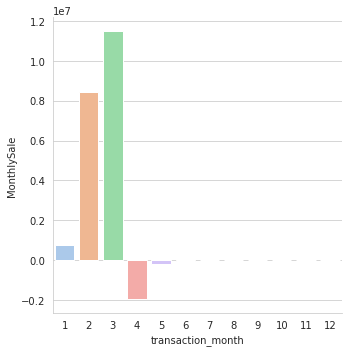

In [101]:
# sns.catplot(x="transaction_month", y="MonthlySale", kind="bar", data=monthly_sale, palette="ch:2.7")
sns.catplot(x="transaction_month", y="MonthlySale", kind="bar", data=monthly_sale, palette="pastel")
plt.savefig(OutDir + 'Monthyly.png')

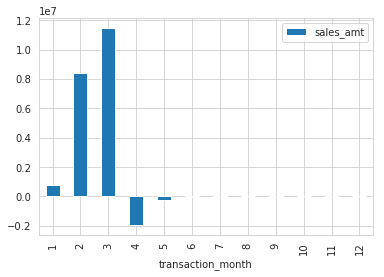

In [102]:
df_items = df[["transaction_month", "sales_amt"]]
df_items.groupby("transaction_month").sum().plot(kind="bar")

### 13. Get a sense of partition of sales price

In [103]:
df.columns

Index(['customer_key', 'transaction_num', 'transaction_date', 'line_num', 'order_status', 'product_key', 'item_qty', 'sales_amt', 'on_sale_flag', 'tot_prd_cst_amt', 'discount_amt', 'promo_cd_key', 'prod_desc', 'mdse_div_id', 'mdse_div_desc', 'mdse_dept_id', 'mdse_dept_desc', 'mdse_class_id', 'mdse_class_desc', 'dept_sty_desc', 'season_desc', 'season_cd', 'promo_code', 'promo_desc', 'eff_date', 'end_date', 'daysinto_promo', 'num_promodays', 'transaction_month', 'return_ind'], dtype='object')

In [104]:
df['sales_amt'].describe()

count    500007.000000
mean         36.890680
std          77.453071
min       -2399.990000
25%          14.980000
50%          48.000000
75%          78.000000
max        2399.990000
Name: sales_amt, dtype: float64

In [107]:
# Lets not use returns
dfsales = df[df['sales_amt'] >= 0]

In [116]:
#____________________
# Décompte des achats
price_range = [0, 25, 50, 75, 100, 200, 5000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = dfsales[(dfsales['sales_amt'] < price) &
                       (dfsales['sales_amt'] > price_range[i-1])]['sales_amt'].count()
    count_price.append(val)

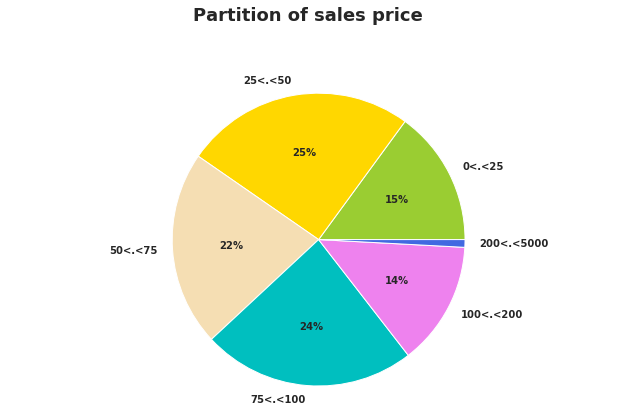

In [117]:

#____________________________________________
# Représentation du nombre d'achats / montant        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Partition of sales price", ha='center', fontsize = 18);
plt.savefig(OutDir + 'Partition of sales price.png')


### 14. Understand negative quantity sales or returns

In [118]:
# Lets check negative item_qty - Do we have corresponding positive item_qty always?
# df[df['sales_amt'] < 0].head()
df_check = df[df['item_qty'] < 0][['customer_key','item_qty', 'transaction_num',
                                                   'transaction_date','product_key','sales_amt']]


In [125]:
print(df.shape)
print(df_check.shape)
df_check.head()

(500007, 30)
(103688, 6)


,customer_key,item_qty,transaction_num,transaction_date,product_key,sales_amt
60,454,-1,2115140194,2017-02-14,5145828887,-101.99
62,454,-1,2115140194,2017-02-14,5145828887,-101.99
64,454,-1,2115140194,2017-02-14,5145828887,-101.99
66,454,-1,2115140194,2017-02-14,5145828887,-101.99
74,454,-1,2147351306,2017-04-14,5599623060,-66.00


In [122]:
# Spotcheck one
ss = df[(df['customer_key'] == '454') & (df['product_key'] == '5145828887')]
ss.head()
# ss = df[df['customer_key'] == '24']

,customer_key,transaction_num,transaction_date,line_num,order_status,product_key,item_qty,sales_amt,on_sale_flag,tot_prd_cst_amt,discount_amt,promo_cd_key,prod_desc,mdse_div_id,mdse_div_desc,mdse_dept_id,mdse_dept_desc,mdse_class_id,mdse_class_desc,dept_sty_desc,season_desc,season_cd,promo_code,promo_desc,eff_date,end_date,daysinto_promo,num_promodays,transaction_month,return_ind
28,454,2113008223,2017-02-09,1,O,5145828887,1,101.99,Y,28.33,-43.35,nan,LS TRENCH DRESCHAMBY,27,PETITES,271,P SUIT/SEP,05,WOVEN DRESSES,LS TRENCH DR,J03 2016,J03,Missing,Missing,NaT,NaT,0.0,0.0,2,0
30,454,2113008223,2017-02-09,1,O,5145828887,1,101.99,Y,28.33,-15.30,37431792.0,LS TRENCH DRESCHAMBY,27,PETITES,271,P SUIT/SEP,05,WOVEN DRESSES,LS TRENCH DR,J03 2016,J03,287373,"15% off purchase, no br exclusions, when you use your banana republic, gap, old navy or athleta credit card",2017-02-02,2017-02-09,7.0,7.0,2,0
32,454,2113008223,2017-02-09,1,O,5145828887,1,101.99,Y,28.33,-14.61,34309379.0,LS TRENCH DRESCHAMBY,27,PETITES,271,P SUIT/SEP,05,WOVEN DRESSES,LS TRENCH DR,J03 2016,J03,251393,get $50 off any purchase on your banana republic credit card,2016-11-01,2017-07-01,242.0,100.0,2,0
34,454,2113008223,2017-02-09,1,O,5145828887,1,101.99,Y,28.33,-2.92,34128061.0,LS TRENCH DRESCHAMBY,27,PETITES,271,P SUIT/SEP,05,WOVEN DRESSES,LS TRENCH DR,J03 2016,J03,258175,get $10 off any purchase on your banana republic credit card,2016-12-01,2017-08-01,243.0,70.0,2,0
60,454,2115140194,2017-02-14,1,O,5145828887,-1,-101.99,Y,-28.33,15.30,37431792.0,LS TRENCH DRESCHAMBY,27,PETITES,271,P SUIT/SEP,05,WOVEN DRESSES,LS TRENCH DR,J03 2016,J03,287373,"15% off purchase, no br exclusions, when you use your banana republic, gap, old navy or athleta credit card",2017-02-02,2017-02-09,7.0,12.0,2,1


In [131]:
dfreturn = pd.DataFrame()

In [133]:
df_check.head()

,customer_key,item_qty,transaction_num,transaction_date,product_key,sales_amt
60,454,-1,2115140194,2017-02-14,5145828887,-101.99
62,454,-1,2115140194,2017-02-14,5145828887,-101.99
64,454,-1,2115140194,2017-02-14,5145828887,-101.99
66,454,-1,2115140194,2017-02-14,5145828887,-101.99
74,454,-1,2147351306,2017-04-14,5599623060,-66.00


In [170]:
dfreturn

""


In [169]:
# Does not seem like always we have correponding positive item_qty
# Ideally we should remove these
count =0
dfreturn = pd.DataFrame()
for index, col in  df_check.iterrows():
    if (df[(df['customer_key'] == col[0]) & (df['item_qty'] == -col[1]) 
                & (df['product_key'] == col[4])].shape[0] == 0): 
        count +=1
        dfreturn.append([col], ignore_index=True)
        if (count == 1):
            df2 = pd.DataFrame([col])
#             ll = [[col]]
        else:
            dd = pd.DataFrame([col])
            df2.append(dd, ignore_index=True)
#             ll.append([col])
        
#         dfreturn.append(df2)
#         print(df.loc[index])
#         print(col[0], col[1], col[2])
        print(col)
        print(count)
        if count == 2:
            break
        print(5*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
#         break
# dd=pd.DataFrame(ll,columns=['customer_key', 'item_qty', 'transaction_num', 'transaction_date', 'product_key',
#                                   'sales_amt'])

TypeError: __init__() got an unexpected keyword argument 'ignore_index'

######################### TODO #################################
### Remove transaction with negative item_qty without a counter part otherwise 
### aggregated values will be misleading
### Hopefully when we have larger date window we will be fine


In [33]:
df.shape

(554, 38)

In [66]:
df_outdate = df[(df['txn_dt'] < '2017-01-29') | (df['txn_dt'] > '2018-02-03')]
print(df_outdate.shape)
df_outdate.head()
#############################################################
# 443/554 out of date range -> Check sql for data pull
#############################################################

(443, 38)


,customer_key,transaction_num,line_num,product_key,item_type,item_qty,sales_amt,on_sale_flag,order_status1,household_key,order_num,order_status2,order_type,txn_dt,cust_acq_source_code,first_purchase_brand_flag,first_purchase_chan_flag,private_label_crdhldr_flag,gross_sales_amt,discount_reason_cd,discount_amt,discount_seq_nbr,discount_level,mkt_pmotn_cd,style_cd,color_cd,size_model_cd,mdse_corp_desc,mdse_comp_desc,dept_sty_desc,season_desc,prod_desc,dept_agg1,dept_agg2,basket_size,basket_price,txn_month,return_ind
8,24,2560576145,1,7157645030,M,1,25.0,N,R,391098395,Missing,R,Missing,2018-04-07,4172837,N,N,N,187.6,Missing,0.0,nan,Missing,Missing,Missing,nan,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,6,187.6,4,0
9,24,2560576145,2,7156880926,M,1,25.0,N,R,391098395,Missing,R,Missing,2018-04-07,4172837,N,N,N,187.6,Missing,0.0,nan,Missing,Missing,Missing,nan,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,6,187.6,4,0
10,24,2560576145,3,7156880926,M,1,25.0,N,R,391098395,Missing,R,Missing,2018-04-07,4172837,N,N,N,187.6,Missing,0.0,nan,Missing,Missing,Missing,nan,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,6,187.6,4,0
11,24,2560576145,4,7178716530,M,1,40.8,N,R,391098395,Missing,R,Missing,2018-04-07,4172837,N,N,N,187.6,Missing,0.0,nan,Missing,Missing,Missing,nan,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,6,187.6,4,0
12,24,2560576145,5,7154459093,M,1,25.0,N,R,391098395,Missing,R,Missing,2018-04-07,4172837,N,N,N,187.6,Missing,0.0,nan,Missing,Missing,Missing,nan,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,6,187.6,4,0


# Finished EDA for now

**Following logic has been moved to database level - so no worries for now**

In [23]:
# Lets create new columns
# How many days promo lasts
df['num_promodays'] = df['end_date'] - df['eff_date']
# How many days a customer waits to buy wihtin a promo
df['days_intopromo'] = df['transaction_date'] - df['eff_date']
# month of transaction
df['transaction_month'] = df['transaction_date'].dt.month
# return indicator
df['return_ind'] = (df['item_qty'] <0)*1

In [25]:
# Lets see the basket size = defined as total item_qty per transaction
# temp = df.groupby(by=['customer_key', 'transaction_num'], as_index=False)['line_num'].count()
temp = df.groupby(by=['customer_key', 'transaction_num'], as_index=False)['item_qty'].count()
nb_products_per_basket = temp.rename(columns = {'item_qty':'basket_size'})
nb_products_per_basket[:10].sort_values('customer_key')

,customer_key,transaction_num,basket_size
0,100006,2110519199,1
1,100090,2117677728,2
2,100275,2116125098,2
3,100275,2130571744,1
4,100346,2136576074,1
5,100349,2110237903,6
6,100349,2110450693,1
7,100349,2115447124,2
8,100349,2116778937,3
9,100349,2117705082,1


In [26]:
# Lets add basket_size to the dataset
df = pd.merge(df, nb_products_per_basket,  how='left', left_on=['customer_key', 'transaction_num'], 
                  right_on = ['customer_key', 'transaction_num'])

In [27]:
# Lets see the basket price
temp = df.groupby(by=['customer_key', 'transaction_num'], as_index=False)['sales_amt'].sum()
basket_price = temp.rename(columns = {'sales_amt':'basket_price'})

In [28]:
# Lets add basket_price to the dataset
df = pd.merge(df, basket_price,  how='left', left_on=['customer_key', 'transaction_num'], 
                  right_on = ['customer_key', 'transaction_num'])

In [92]:
# Lets remove all the description columns
df = df.loc[:, ~df.columns.str.endswith('_desc')]

In [105]:
# Consider all categorical columns
catData = df.select_dtypes(include=['object'])
catCol = catData.columns
# Lets ingone a few for now
# discount_reason_cd, discount_seq_nbr
catColToOneHot = [item for item in catCol if item not in ['customer_key', 'transaction_num', 'product_key',
                    'discount_reason_cd', 'discount_seq_nbr', 'mkt_pmotn_cd','promo_cd_key',
                    'style_cd', 'style_color_cd', 'promo_descex','mdse_dept_id', 'color_cd',
                    'promo_descext','promo_code','season_cd']]
print(catColToOneHot)

['order_status', 'on_sale_flag', 'discount_level', 'mdse_corp_id', 'mdse_comp_id', 'mdse_div_id', 'mdse_class_id', 'market_code', 'size_model_cd', 'promo_dollar', 'promo_percent']


In [18]:
# unique counts
def unique_counts(sample):
    cols= [item for item in sample.columns if item not in ['adjusted_net_worth', 'age', 'age_range_in_hh',
                                                          'cd_link','children_0_3_years', 'children_13_18_years',
                                                           'children_4_7_years', 'children_8_12_years',
                                                          'cust_key','dma_code','ethnic_code','flow_key',
                                                          'length_of_residence', 'mega_age',
                                                           'merkle_marketing_index', 'msa_code',
                                                          'nm1_birthdate', 'prob_ordering_through_internet',
                                                          'prob_ordering_through_mail','prob_ordering_through_phone',
                                                          'spendex_apparel', 'spendex_plus', 'crt_tmst', 'updt_tmst']]
#     print(cols)
    for i in cols:
        count = sample[i].nunique()
        valuecount = sample[i].value_counts()
        print(i, ": ", count)
#         print(i, ": ", count, "\n", valuecount)
unique_counts(df)

customer_key :  126
transaction_num :  313
transaction_date :  78
line_num :  16
order_status :  2
product_key :  476
item_qty :  4
sales_amt :  274
on_sale_flag :  2
tot_prd_cst_amt :  520
discount_reason_cd :  12
discount_amt :  446
discount_seq_nbr :  5
discount_level :  3
mkt_pmotn_cd :  109
promo_cd_key :  65
prod_desc :  356
mdse_corp_id :  2
mdse_corp_desc :  2
mdse_comp_id :  2
mdse_comp_desc :  2
mdse_div_id :  11
mdse_div_desc :  6
mdse_dept_id :  39
mdse_dept_desc :  24
mdse_class_id :  9
mdse_class_desc :  45
dept_sty_desc :  285
style_cd :  306
color_cd :  23
market_code :  2
style_color_cd :  381
size_model_cd :  13
season_desc :  46
season_cd :  42
promo_code :  65
promo_desc :  32
promo_type_code :  1
eff_date :  23
end_date :  23
use_cd :  0
brand_cd :  0
num_promodays :  14


In [26]:
# Lets see how many products, transactions and customers
pd.DataFrame([{'products': len(df['product_key'].value_counts()),    
               'transactions': len(df['transaction_num'].value_counts()),
               'customers': len(df['customer_key'].value_counts())
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,558,316,268


In [30]:
# Lets check one more time - get some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)


,customer_key,transaction_num,transaction_date,line_num,order_status,product_key,item_qty,sales_amt,on_sale_flag,tot_prd_cst_amt,discount_reason_cd,discount_amt,discount_seq_nbr,discount_level,mkt_pmotn_cd,promo_cd_key,prod_desc,mdse_corp_id,mdse_corp_desc,mdse_comp_id,mdse_comp_desc,mdse_div_id,mdse_div_desc,mdse_dept_id,mdse_dept_desc,mdse_class_id,mdse_class_desc,dept_sty_desc,style_cd,color_cd,market_code,style_color_cd,size_model_cd,season_desc,season_cd,promo_code,promo_desc,promo_type_code,eff_date,end_date,use_cd,brand_cd,num_promodays,days_intopromo
column type,int64,int64,datetime64[ns],int64,object,int64,int64,float64,object,float64,object,float64,float64,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,object,object,object,object,object,object,object,datetime64[ns],datetime64[ns],object,object,timedelta64[ns],timedelta64[ns]
null values (nb),0,0,0,0,0,0,0,0,0,0,600,141,141,541,160,352,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,352,352,352,352,352,1000,1000,352,352
null values (%),0,0,0,0,0,0,0,0,0,0,60,14.1,14.1,54.1,16,35.2,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,14.1,35.2,35.2,35.2,35.2,35.2,100,100,35.2,35.2


In [132]:
# monthly_plot = monthly_sale['MonthlySale'].plot(kind='bar')
# monthly_plot.set_xlabel("Months")
# monthly_plot.set_ylabel("Units")

In [133]:
# # Lets look at the line order per month
# plt.figure(figsize=(12,6))
# sns.barplot(monthly_sale.index, monthly_sale.values, alpha=0.8)#, color=color[3])
# plt.xticks(rotation='vertical')
# plt.xlabel('Month of transaction', fontsize=12)
# plt.ylabel('Number of Occurrences', fontsize=12)
# plt.savefig('Output/trans_permonth.png')
# plt.show()# Not many transaction data in Nov and Dec

In [50]:

df.groupby(["order_status"]).sum().sort_values("item_qty", ascending=False)

,customer_key,transaction_num,line_num,product_key,item_qty,sales_amt,tot_prd_cst_amt,discount_amt,discount_seq_nbr,promo_cd_key,color_cd,market_code
order_status,,,,,,,,,,,,
R,3200451,1049895673208,1398,2463920343808,374,18975.16,5765.11,-3698.42,538.0,1.088042e+10,884.0,402.0
O,2952938,1075837787935,1341,2698832294922,255,21047.71,5311.23,-4359.09,772.0,1.290015e+10,985.0,918.0


In [51]:
df.groupby(["order_status"]).sum().sort_values("sales_amt", ascending=False)

,customer_key,transaction_num,line_num,product_key,item_qty,sales_amt,tot_prd_cst_amt,discount_amt,discount_seq_nbr,promo_cd_key,color_cd,market_code
order_status,,,,,,,,,,,,
O,2952938,1075837787935,1341,2698832294922,255,21047.71,5311.23,-4359.09,772.0,1.290015e+10,985.0,918.0
R,3200451,1049895673208,1398,2463920343808,374,18975.16,5765.11,-3698.42,538.0,1.088042e+10,884.0,402.0


In [54]:
group = df.groupby(["order_status","mdse_div_id"]).sum()
total_price = group["sales_amt"].groupby(level=0, group_keys=False)
total_price.nlargest(5)

order_status  mdse_div_id
O             22             10240.24
              24              2672.99
              23              2393.81
              21              2300.30
              27              1613.19
R             12             11910.35
              11              2619.52
              Missing         2228.11
              13              1094.07
              14               633.99
Name: sales_amt, dtype: float64

In [55]:
group = df.groupby(["order_status","mdse_dept_id"]).sum()
total_price = group["sales_amt"].groupby(level=0, group_keys=False)
total_price.nlargest(5)

order_status  mdse_dept_id
O             221             4376.31
              242             2386.99
              222             1836.00
              224             1726.58
              211             1710.98
R             121             2773.47
              122             2691.31
              126             2273.27
              Missing         2228.11
              124             1939.36
Name: sales_amt, dtype: float64

In [57]:
group = df.groupby(["order_status","season_desc"]).sum()
total_price = group["sales_amt"].groupby(level=0, group_keys=False)
total_price.nlargest(5)

order_status  season_desc
O             F04 2017       4006.19
              BASIC          3067.44
              F03 2017       1949.26
              J04 2016       1642.00
              Missing        1533.18
R             F04 2017       2892.98
              F03 2017       2789.34
              Missing        2228.11
              M04 2017       1333.60
              J04 2016       1121.47
Name: sales_amt, dtype: float64

In [34]:
# df_outdate['txn_dt']

### Lets prepare Customer level aggregated dataset
number of transactions, total amount spent, min/max/average amount spent, number of times returned, number of unique products purchased, number of unique promocode used, min/max/avearage basket size

In [51]:
# total amount spent, min/max/average amount spent
temp = df.groupby(by=['customer_key'])['basket_price'].agg(['min','max','mean','sum'])


In [52]:
customer = temp.rename(columns = {'min':'min_basketprice', 
                                  'max':'max_basketprice', 'mean':'avg_basketprice',
                                 'sum':'total_basketprice'})

In [53]:
customer.head()

,min_basketprice,max_basketprice,avg_basketprice,total_basketprice
customer_key,,,,
101883,1184.00,1184.00,1184.000,14208.00
102077,196.00,196.00,196.000,588.00
102397,63.98,63.98,63.980,127.96
102486,19.99,19.99,19.990,19.99
102596,-64.80,188.09,114.054,570.27


In [54]:
# number of times returned
temp = df.groupby(by=['customer_key'])['return_ind'].agg(['sum'])
temp2 = temp.rename(columns = {'sum':'times_returned'})

In [55]:
# Lets add basket_price to the dataset
customer = pd.merge(customer, temp2,  how='left', left_on=['customer_key'], 
                  right_on = ['customer_key'])

In [56]:
customer.head()

,min_basketprice,max_basketprice,avg_basketprice,total_basketprice,times_returned
customer_key,,,,,
101883,1184.00,1184.00,1184.000,14208.00,0
102077,196.00,196.00,196.000,588.00,0
102397,63.98,63.98,63.980,127.96,0
102486,19.99,19.99,19.990,19.99,0
102596,-64.80,188.09,114.054,570.27,1


In [57]:
# number of transactions
customer['num_trans'] = df.groupby('customer_key').transaction_num.nunique()

In [58]:
# number of unique products purchased
customer['num_products'] = df.groupby('customer_key').product_key.nunique()

In [59]:
# number of unique promocode used, min/max/avearage basket size
customer['num_promocode'] = df.groupby('customer_key').mkt_pmotn_cd.nunique()

In [60]:
# total amount spent, min/max/average amount spent
temp = df.groupby(by=['customer_key'])['basket_size'].agg(['min','max','mean','sum'])


In [61]:
temp2 = temp.rename(columns = {'min':'min_basketsize', 
                                  'max':'max_basketsize', 'mean':'avg_basketsize',
                                 'sum':'total_basketsize'})

In [62]:
# Lets add basket_price to the dataset
customer = pd.merge(customer, temp2,  how='left', left_on=['customer_key'], 
                  right_on = ['customer_key'])

In [63]:
customer.head()

,min_basketprice,max_basketprice,avg_basketprice,total_basketprice,times_returned,num_trans,num_products,num_promocode,min_basketsize,max_basketsize,avg_basketsize,total_basketsize
customer_key,,,,,,,,,,,,
101883,1184.00,1184.00,1184.000,14208.00,0,1,3,4,12,12,12.0,144
102077,196.00,196.00,196.000,588.00,0,1,2,1,3,3,3.0,9
102397,63.98,63.98,63.980,127.96,0,1,1,2,2,2,2.0,4
102486,19.99,19.99,19.990,19.99,0,1,1,1,1,1,1.0,1
102596,-64.80,188.09,114.054,570.27,1,3,4,1,1,3,2.2,11


In [51]:
customer.dtypes

min_basketprice      float64
max_basketprice      float64
avg_basketprice      float64
total_basketprice    float64
times_returned         int64
num_trans              int64
num_products           int64
num_promocode          int64
min_basketsize         int64
max_basketsize         int64
avg_basketsize       float64
total_basketsize       int64
dtype: object

In [52]:
# Save this dataframe for now
# customer.to_csv(DataDir + "CustomerData2.csv", index=False)
customer.to_csv(DataDir + "CustomerData.csv")